In [11]:
# Stop warnings
import warnings
warnings.filterwarnings("ignore")

# Imports
import os
import sys
import json
import cortex
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt


# Personal imports
sys.path.append("{}/../../../analysis_code/utils".format(os.getcwd()))
from plot_utils import *
from pycortex_utils import draw_cortex, set_pycortex_config_file, load_surface_pycortex, create_colormap, get_rois
from surface_utils import load_surface

In [5]:
# Directories
main_dir = '/Users/uriel/disks/meso_shared'
project_dir = 'RetinoMaps'

In [6]:
# Set pycortex db and colormaps
cortex_dir = "{}/{}/derivatives/pp_data/cortex".format(main_dir, project_dir)
set_pycortex_config_file(cortex_dir)

# Webgl port
port_num = 25000

# MMP atlas

## Creat the colormap

In [7]:
mmp_colormap_fn = '{}/db/sub-170k/Glasser2016_ColorLUT.txt'.format(cortex_dir)

In [16]:
# creating an MMP colormap as png
np_cmap = pd.read_csv(mmp_colormap_fn, delimiter='\t')[[' R ',' G ',' B ', ' A ']].astype(np.uint8)
np_cmap[' A '] = np.ones(np_cmap.shape[0], dtype=np.uint8) * 255
png = np.zeros((1,256,4), dtype=np.uint8)
png[0,:np.array(np_cmap).shape[0],:] = np.array(np_cmap)
im = Image.fromarray(png, 'RGBA')
im.save('{}/colormaps/HCP_MMP1.png'.format(cortex_dir))
plt.matshow(png)
plt.axis('off')

(-0.5, 255.5, 0.5, -0.5)

## Plot mmp atlas

In [41]:
# Settings
subject = 'sub-170k'
pycortex_subject = 'sub-170k'

In [30]:
# Load mmp atlas rois
mmp_rois_dir = '{}/{}/derivatives/pp_data/{}/170k/rois/{}_rois_mmp.dtseries.nii'.format(main_dir, project_dir, subject, subject)

results = load_surface_pycortex(brain_fn=mmp_rois_dir)
mmp_rois_data = results['data_concat']

In [44]:
colormap_dict = {'n/a': (255, 255, 255),
                 'V1': (243, 231, 155),
                 'V2': (250, 196, 132),
                 'V3': (248, 160, 126),
                 'V3AB': (235, 127, 134),
                 'LO': (150, 0, 90), 
                 'VO': (0, 0, 200),
                 'hMT+': (0, 25, 255),
                 'iIPS': (0, 152, 255),
                 'sIPS': (44, 255, 150),
                 'iPCS': (151, 255, 0),
                 'sPCS': (255, 234, 0),
                 'mPCS': (255, 111, 0)}

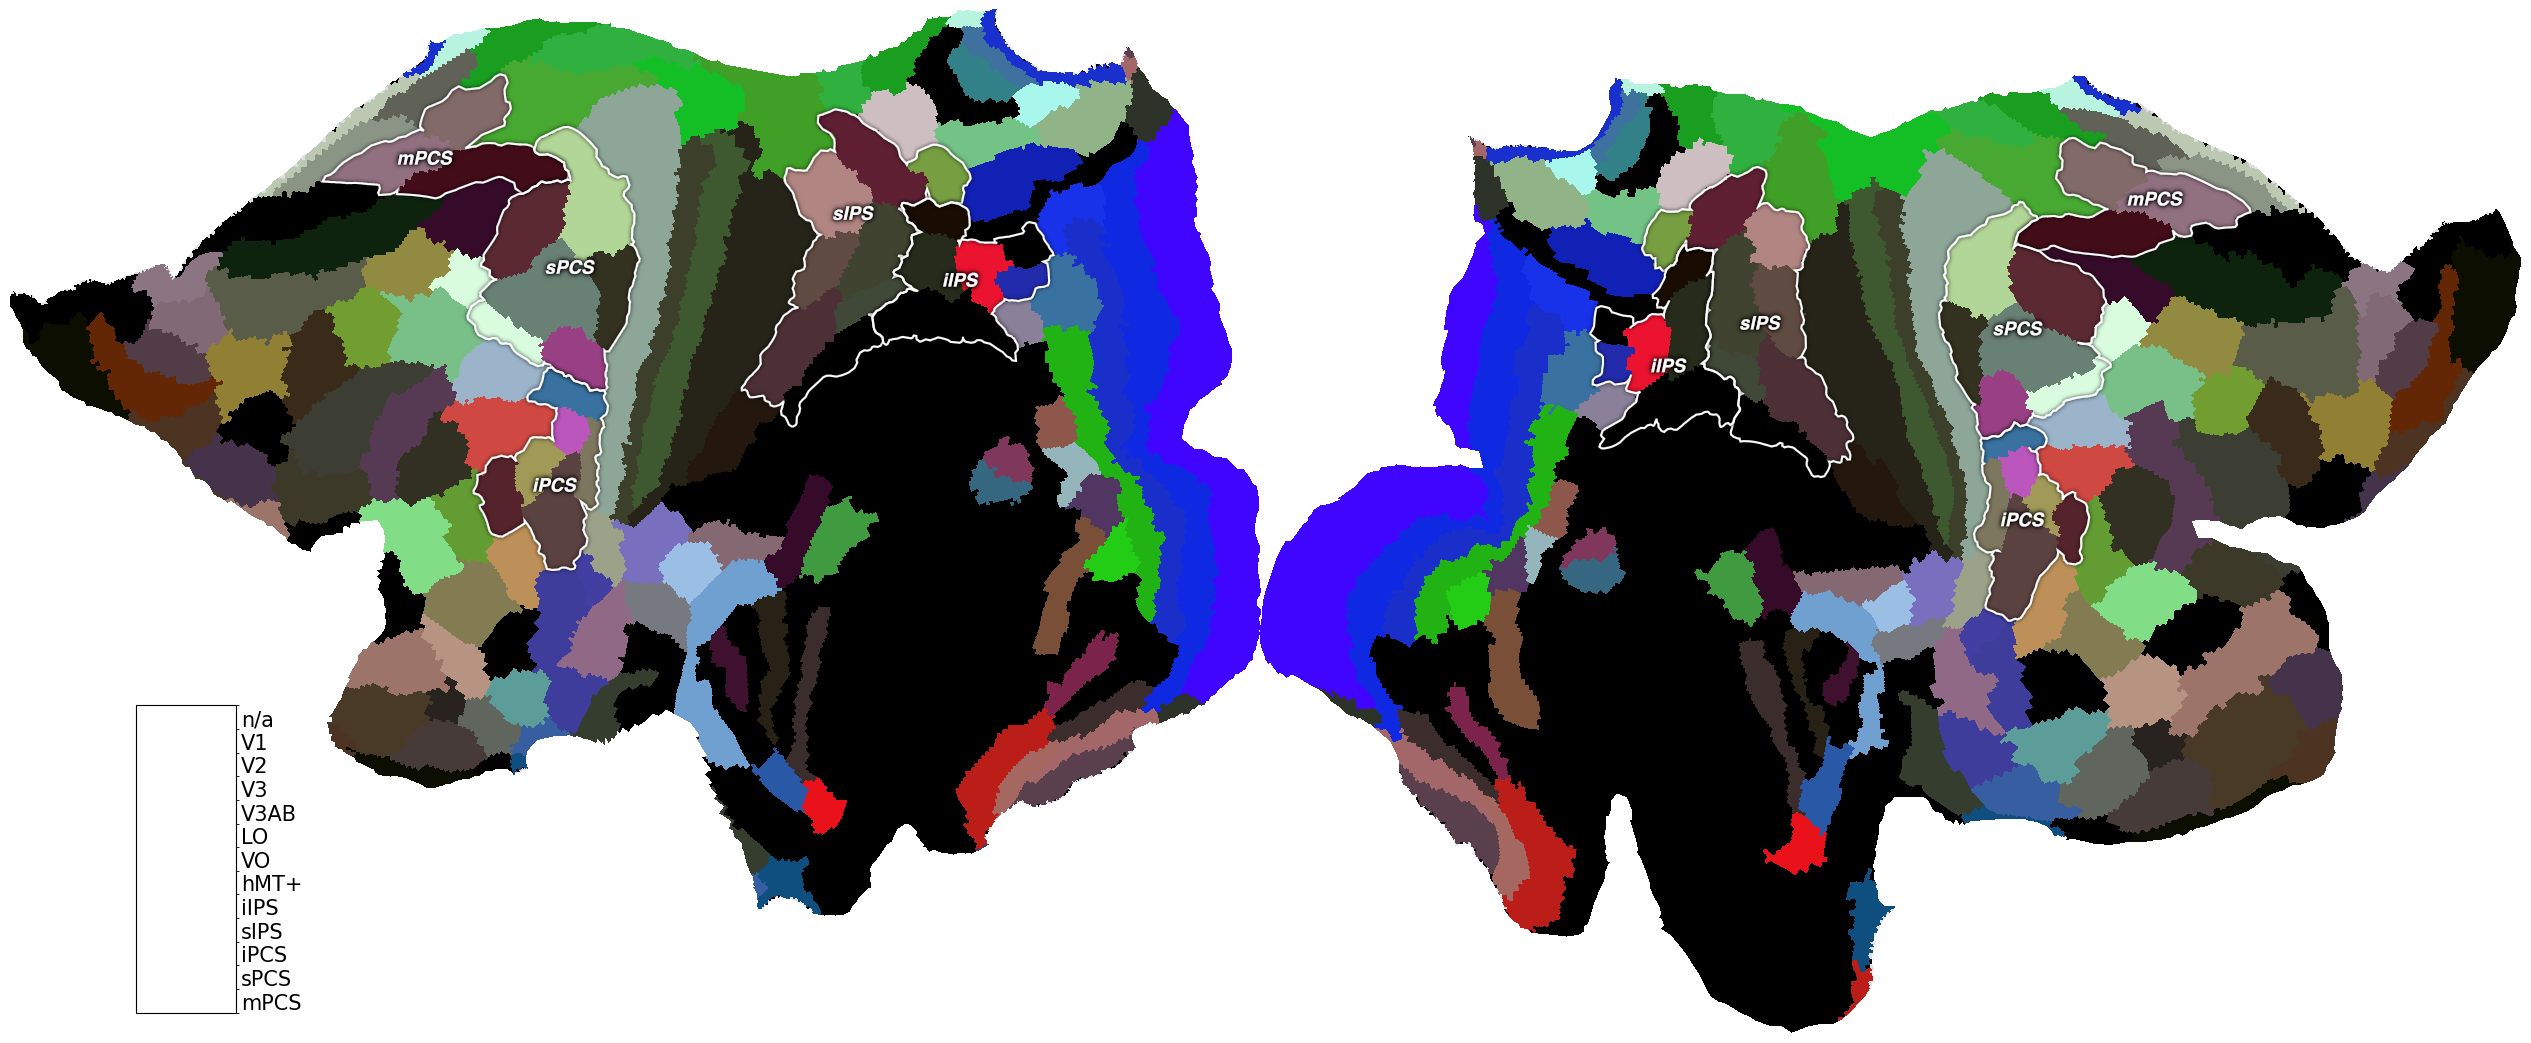

In [56]:
colormap_name = 'HCP_MMP1'

# vertex_data = cortex.Vertex(mmp_array, pycortex_subject, cmap=colormap_name)


rois_opacity = 1

# load rois mask
rois_dict_mmp_group = get_rois(subject=subject, return_concat_hemis=True, return_hemi=None, rois=None, mask=True, atlas_name='mmp_group', surf_size='59k')
rois_dict_mmp = get_rois(subject=subject, return_concat_hemis=True, return_hemi=None, rois=None, mask=True, atlas_name='mmp', surf_size='59k')

# Defind masks
frontal_mask = rois_dict_mmp_group['iPCS'] | rois_dict_mmp_group['sPCS'] | rois_dict_mmp_group['mPCS']
parietal_mask = rois_dict_mmp_group['iIPS'] | rois_dict_mmp_group['sIPS']
parietal_frontal_mask = rois_dict_mmp_group['iPCS'] | rois_dict_mmp_group['sPCS'] | rois_dict_mmp_group['mPCS'] | rois_dict_mmp_group['iIPS'] | rois_dict_mmp_group['sIPS']

rois_cibles = ["LIPv", "LIPd", "FEF", "SCEF"]
eye_mvt_mask = np.logical_or.reduce([rois_dict_mmp.get(roi, False) for roi in rois_cibles])

all_rois_mask = np.logical_or.reduce([rois_dict_mmp.get(roi, False) for roi in rois_dict_mmp.keys()])

# Choos wich mask to apply
# rois_mask = eye_mvt_mask#.reshape(1,-1)
# rois_mask = parietal_frontal_mask
rois_mask = all_rois_mask

# Alpha mat
alpha_mat = mmp_rois_data*0+rois_opacity
alpha_mat[mmp_rois_data==0]=0
rois_mask = rois_mask.reshape(1,-1)
alpha_mat[~rois_mask] = 0

# Pycortex settings
roi_name = 'brain_170k'
param_rois = {'subject': pycortex_subject,
              'data': mmp_rois_data, 
              'cmap': colormap_name,
              'alpha': alpha_mat,
              'cbar': 'discrete_personalized', 
              'vmin': 0,
              'vmax': 180,
              'cmap_steps': 180,
              'cmap_dict': colormap_dict,
              'cortex_type': 'VertexRGB',
              'description': 'Gaussian pRF ROIs',
              'curv_brightness': 1, 
              'curv_contrast': 0.25,
              'add_roi': False,
              'with_labels': True,
              'roi_name': roi_name}

# Plot
volume_roi = draw_cortex(**param_rois)



In [84]:
port_num = port_num + 1

# Remome overlays_visible=('sulci','roi'), to have borders 
print("Go to (in 5 s...): http://localhost:{}/".format(port_num))
handle = cortex.webgl.show(data=volume_roi,
                           recache=True,
                           port=port_num,
                           overlays_visible=('rois',),
                           labels_visible=()
                          )

Go to (in 5 s...): http://localhost:25013/
Generating new ctm file...
wm
wm
inflated
inflated
Started server on port 25013


In [85]:
# inflated
inflated_general = {'camera.azimuth':241,
                    'camera.altitude':60,
                    'camera.radius':430,
                    'surface.{subject}.unfold':0.5,
                    'surface.{subject}.pivot':46,
                    'surface.{subject}.left':True,
                    'surface.{subject}.right':True,
                    'surface.{subject}.depth':1,
                    'surface.{subject}.specularity':0,
                    'surface.{subject}.layers':4,
                    'surface.{subject}.dither':False,
                    'surface.{subject}.colorbar':False,
                    'surface.{subject}.sampler':'nearest',
                    'surface.{subject}.curvature.brightness':0.25,
                    'surface.{subject}.curvature.contrast':0.25,
                    'surface.{subject}.curvature.smoothness':1}
handle._set_view(**inflated_general)
time.sleep(5)

inflated_dir = '/Users/uriel/Downloads/'
im1 = handle.getImage('{}/inflated_mmp.png'.format(inflated_dir),size = (3000, 3000))

Stopping server
